In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

data = []
labels = []
classes = {0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'clothes', 4: 'glass',
           5: 'metal', 6: 'paper', 7: 'plastic', 8: 'shoes'}
cur_path = os.getcwd()


In [17]:
#Retrieving the images and their labels 
for key,i in classes.items():
    path = os.path.join(cur_path,'garbage_classification',i)
    images = os.listdir(path)
    for a in images:
        image = Image.open(path + '\\'+ a).convert('RGB')
        image = image.resize((71, 71))
        image = np.array(image)
        #sim = Image.fromarray(image)
        data.append(image)
        labels.append(key)
        

In [18]:
labelssss = labels
dataaaa = data

In [19]:
labels = labelssss
data = dataaaa

In [20]:
#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

In [21]:
print(data.shape, labels.shape)
#Splitting training and testing dataset

data = data.astype('float32')
labels = labels.astype('float32')
# normalize to range 0-1
data = data / 255.0

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 9)
y_test = to_categorical(y_test, 9)

(24673, 71, 71, 3) (24673,)
(19738, 71, 71, 3) (4935, 71, 71, 3) (19738,) (4935,)


In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=64)

In [23]:
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.optimizers import SGD

# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
# model.add(BatchNormalization())
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))
# model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.3))
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(9, activation='softmax'))
# # compile model
# opt = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [24]:
from keras.applications.xception import Xception
from keras.models import Model
# load model
model = Xception(include_top=False, input_shape=(71, 71, 3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
Pooling = tf.keras.layers.GlobalAveragePooling2D()(model.layers[-1].output)
flat1 = Flatten()(Pooling)
output = Dense(9, activation='softmax')(flat1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]']    

c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 block2_sepconv1 (SeparableConv  (None, 33, 33, 128)  8768       ['block1_conv2_act[0][0]']       
 2D)                                                                                              
                                                                                                  
 block2_sepconv1_bn (BatchNorma  (None, 33, 33, 128)  512        ['block2_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block2_sepconv2_act (Activatio  (None, 33, 33, 128)  0          ['block2_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block2_se

In [25]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

In [27]:
epochs = 50
history = model.fit(it_train, steps_per_epoch=int(X_train.shape[0] / 64), epochs=epochs, validation_data=(X_test, y_test), callbacks=early_stop)
# history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test), callbacks=early_stop)
model.save("my_model.h5")

Epoch 1/50
308/308 [==============================] - 301s 975ms/step - loss: 0.3360 - accuracy: 0.4156 - val_loss: 0.2960 - val_accuracy: 0.5167
Epoch 2/50
308/308 [==============================] - 285s 927ms/step - loss: 0.2808 - accuracy: 0.5579 - val_loss: 0.2603 - val_accuracy: 0.6036
Epoch 3/50
308/308 [==============================] - 256s 832ms/step - loss: 0.2541 - accuracy: 0.6136 - val_loss: 0.2399 - val_accuracy: 0.6413
Epoch 4/50
308/308 [==============================] - 271s 879ms/step - loss: 0.2371 - accuracy: 0.6422 - val_loss: 0.2269 - val_accuracy: 0.6610
Epoch 5/50
308/308 [==============================] - 253s 823ms/step - loss: 0.2265 - accuracy: 0.6636 - val_loss: 0.2177 - val_accuracy: 0.6754
Epoch 6/50
308/308 [==============================] - 260s 844ms/step - loss: 0.2190 - accuracy: 0.6759 - val_loss: 0.2109 - val_accuracy: 0.6837
Epoch 7/50
308/308 [==============================] - 269s 874ms/step - loss: 0.2121 - accuracy: 0.6806 - val_loss: 0.2053 -

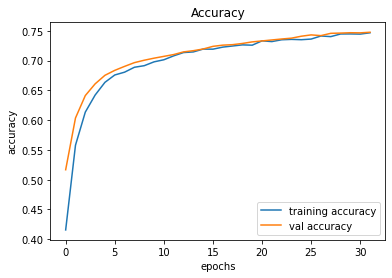

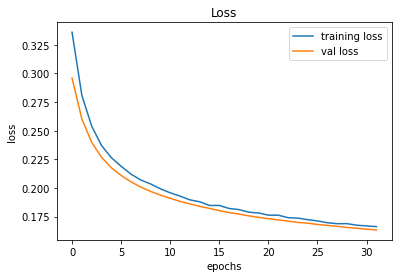

In [28]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import classification_report
preds = model.predict(X_test)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
# preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
# labels = X_test['category'].to_numpy()
print(classification_report(y_test.argmax(1), preds))

155/155 [==============================] - 50s 305ms/step
              precision    recall  f1-score   support

           0       0.70      0.63      0.66       389
           1       0.78      0.69      0.73       379
           2       0.82      0.52      0.64       190
           3       0.81      0.88      0.84      1201
           4       0.75      0.62      0.68       402
           5       0.64      0.45      0.53       375
           6       0.71      0.53      0.61       204
           7       0.70      0.86      0.77      1419
           8       0.80      0.75      0.77       376

    accuracy                           0.75      4935
   macro avg       0.75      0.66      0.69      4935
weighted avg       0.75      0.75      0.74      4935

